# Part 1: Recognition

In this part of the assignment, you will implement and train neural networks, including convolutional neural networks, for an image recognition task using PyTorch. Specifically, we will classify a number of grayscale images of pieces of clothing by predicting a label for the name of the clothing type.

**Learning objectives.** You will:
1. Define multilayer perceptrons and convolutional neural networks using PyTorch
2. Optimize neural networks using automatic differentation and minibatch stochastic gradient descent in PyTorch
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch

## Getting Started

We recommend that you start by reviewing the extremely concise [PyTorch Quickstart tutorial](https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html), which will help familiarize you with the API and the tasks below. You can also review more specific concepts in more detail beyond the quickstart -- there are additional tutorial pages with more details on tensors, Datasets and Dataloaders, etc.

Once you are ready to get started experimenting yourself, run the following code to import relevant PyTorch modules, download the dataset, split into a train, validation, and test dataset, and prepare PyTorch dataloaders for batching.

In [4]:
# Run but DO NOT MODIFY this code

# Import modules
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Set a random seed for reproducibility
torch.manual_seed(2025)

# Load Fashion MNIST datasets
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Then run the following code to visualize some random examples of the training data. You will see that you are working with grayscale images of clothing articles belonging to one of ten labeled classes. Our goal will be to build predictive models that take an image as input and predict the class to which they belong (e.g., is this an image of a T-Shirt or a Sneaker?)

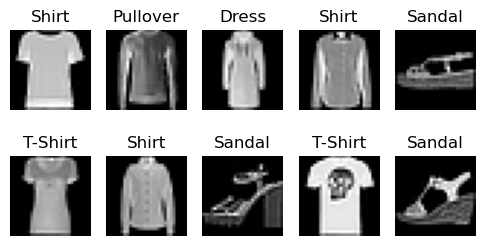

In [6]:
# Run but DO NOT MODIFY this code

# Visualize Random Examples
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

from matplotlib import pyplot as plt

figure = plt.figure(figsize=(6, 3))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Run the following code to define a helper function for visualizing your model training and validation performance.

In [8]:
# Run but DO NOT MODIFY this code

from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.
    
    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).
        
    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.
        
    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## Task 1

In this task you will build and train an MLP classifier using PyTorch and CPU compute.

**1. Define a multilayer perceptron [using PyTorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)** to classify the Fashion-MNIST images. Your architecture should:
  - [Flatten](https://docs.pytorch.org/docs/stable/generated/torch.flatten.html) the 28×28 input images to vectors of size 784
  - Contain at least two [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (i.e., at least one hidden layer plus one output layer). The basic structure is: **input → hidden → output**. You may use a deeper model with additional hidden layers (like two hidden layers + one output layer), but this is not required. 
  - Use nonlinear activations ([ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) recommended) for hidden layers
  - Have 10 output units for the classification task
  - Use no more than 100,000 total model parameters. Recall that there are many more parameters than the number of units (you should probably use hidden layers with a number of hidden units in the tens, say between 32 and 96).

**2. Train your model** to minimize the [Cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) on the training data. For this task simply use the CPU for training (this is the default and does not require you to do anything). For training, you should:
  - Use the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) that implements standard minibatch stochastic gradient descent, or the [Adam optimizer](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html). You may need to adjust hyperparameters (e.g., for the learning rate, momentum, etc.) but can start with the default values.
  - Evaluate and record the training loss and validation accuracy once per epoch so that you can visualize training performance using the `plot_training_curves` function defined above.
  - Implement early stopping so that your model stops training if the validation accuracy does not improve for a few consecutive epochs (a concept known as 'patience'). While you can set the patience value to 1 (stop after the first epoch with no improvement), you might get better results with a patience of 2 or 3 to avoid stopping prematurely due to minor fluctuations. You may also want to set a maximum number of epochs (e.g., 10 or 20) to ensure that the code terminates in a reasonable amount of time even if training hyperparameters are suboptimal.
  - Record the amount of time it takes (in seconds) to train the model (you will be asked to use this again later in task 2). You can use Python's [`time()` functionality](https://docs.python.org/3/library/time.html#time.time) or you can very simply note the amount of time that the code cell runs (this will take long enough that you do not need to be extremely precise with measuring).
  - Note that the `train_loader` and `val_loader` defined above can be used for automatic batching and shuffling the training and validation data during training. 
  - Note that the `test_loader` should not be used in this task.
    
**Your goal is to achieve a validation accuracy of 84% or better using no more than 100,000 total model parameters.**

Once you reach this goal, **report the following:**
  - Use the `plot_training_curves` function to visualize the training results
  - Report the total number of model parameters. Show your work for the number of model parameters, either by showing your calculations or showing the code you used to count the number of model parameters ([The .parameters() method will return an iterable over the model parameters](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)).
  - Report the amount of time that was required to train your model in seconds.

cpu Epoch 1 : Training Loss 0.5863507179617882 | Validation Accuracy 0.8476666666666667
cpu Epoch 2 : Training Loss 0.4050983699758848 | Validation Accuracy 0.8534166666666667
cpu Epoch 3 : Training Loss 0.36967041923602423 | Validation Accuracy 0.8584166666666667
cpu Epoch 4 : Training Loss 0.338387906173865 | Validation Accuracy 0.864
cpu Epoch 5 : Training Loss 0.32006035567323365 | Validation Accuracy 0.8775833333333334
cpu Epoch 6 : Training Loss 0.30664001624782883 | Validation Accuracy 0.8784166666666666
cpu Epoch 7 : Training Loss 0.28840512654185296 | Validation Accuracy 0.8744166666666666
cpu Epoch 8 : Training Loss 0.2769059027036031 | Validation Accuracy 0.8773333333333333
cpu Epoch 9 : Training Loss 0.2656029132107894 | Validation Accuracy 0.8790833333333333
cpu Epoch 10 : Training Loss 0.2578707854449749 | Validation Accuracy 0.8929166666666667
cpu Epoch 11 : Training Loss 0.24979929088056088 | Validation Accuracy 0.8925833333333333
cpu Epoch 12 : Training Loss 0.23939240

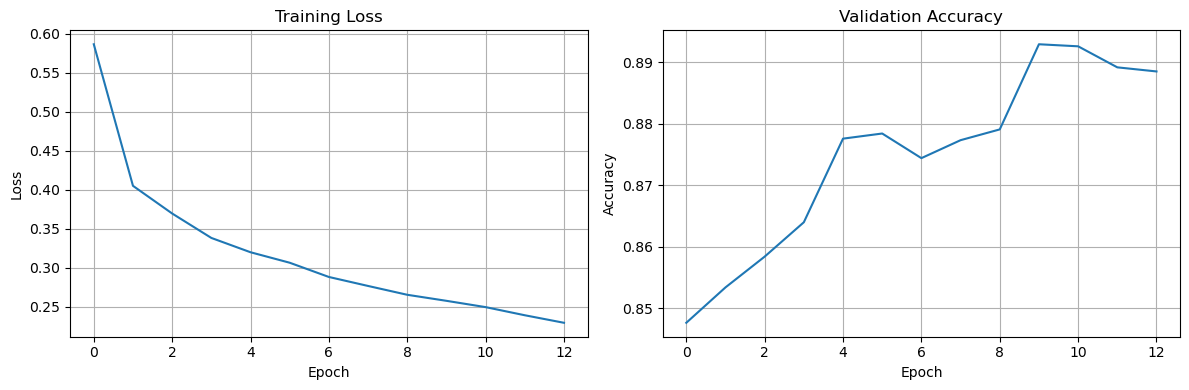

In [10]:
import torch.nn as nn
import time
# Write code for task 1 here

# Setting a random seed for reproducibility
torch.manual_seed(2025)

class MLP(torch.nn.Module):
    """Definition of a multilayer perceptron for classification 
    in Pytorch, inheriting from the torch.nn.Module base class."""
    def __init__(self):
        super(MLP, self).__init__()
        # TODO: finish constructor/initialization        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        """ Compute logits for batch x by forward propagation.
        Parameters
        ----------
        x : tensor, shape = [n_examples, n_channels, width, height]
        """
        # TODO: implement forward propagation
        return self.network(x)

def training(device, max_epochs = 20, patience = 3, lr = 0.001):
    model = MLP().to(device)
    CEL = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    s = 0
    best_accuracy = 0.0
    train_losses = []
    val_accuracies = []
    start_time = time.time()
    for epoch in range(1, max_epochs + 1):
        model.train()
        sum_loss = 0.0
        n_train = 0
        for x, y in train_loader:
            xb = x.to(device)
            yb = y.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = CEL(logits, yb)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)
        average_train_loss = sum_loss / n_train
        train_losses.append(average_train_loss)
        model.eval()
        with torch.no_grad():
            correct = 0
            n = 0
            for x, y in val_loader:
                xb = x.to(device)
                yb = y.to(device)
                correct += (model(xb).argmax(1) == yb).sum().item()
                n += yb.size(0)
            val_accuracy = correct / n
            val_accuracies.append(val_accuracy)
        print(device, "Epoch", epoch, ": Training Loss", average_train_loss, "| Validation Accuracy", val_accuracy)
        if val_accuracy > best_accuracy + 0.0001:
            best_accuracy = val_accuracy
            s = 0
        else:
            s += 1
            if s >= patience:
                break
    training_time = time.time() - start_time
    total_parameters = sum(param.numel() for param in model.parameters())
    return train_losses, val_accuracies, best_accuracy, training_time, total_parameters

device = torch.device("cpu")
CPU_train_losses, CPU_val_accuracies, CPU_best_accuracy, CPU_time, CPU_total_parameters = training(device)
print("The best validation accuracy is", CPU_best_accuracy)
print("The total number of parameters is", CPU_total_parameters)
print("The training time is", CPU_time)
plot_training_curves(CPU_train_losses, CPU_val_accuracies)

Between the input layer and the first hidden layer, there are 78,500 parameters ((784 X 100) + 100 = 78,500) since there are 78,400 weights (784 X 100 = 78,400) and 100 biases. Between the first hidden layer and the second hidden layer, there are 10,100 parameters ((100 X 100) + 100 = 10,100) since there are 10,000 weights (100 X 100 = 10,000) and 100 biases. Between the second hidden layer and the output, there are 1,010 parameters ((100 X 10) + 10 = 1,010) since there are 1,000 weights (100 * 10 = 1,000) and 10 biases. So in total, there are 89,610 parameters (78,500 + 10,100 + 1,010 = 89,610). As for time, it varies but it is somewhere between 19 and 23 seconds.

## Task 2

Train the **exact same** multilayer perceptron architecture that you defined in Task 1, exactly as you trained it in Task 1, but this time **use GPU compute to accelerate the training.** A GPU is a Graphics Processing Unit and is specialized to efficiently compute intensive but highly parallel operations such as matrix multiplications.

If you are running this code on the Google Colab or a CS Department Compute Cluster OnDemand, you should have access to a CUDA enabled GPU device. In both cases you will need to specifically request a GPU. Using OnDemand, you should request a device from gpu partition and request 1 GPU. To change the Runtime in Google Colab, on the top drop-down menu select Runtime, then select Change runtime type. Under Hardware accelerator, select T4 GPU, then click Save.

See the [CUDA semantics documentation](https://pytorch.org/docs/stable/notes/cuda.html#cuda-semantics) for details, or the quick tips for common operations below.
  - Check GPU availability: `torch.cuda.is_available()`
  - Create device object: for example: `torch.device('cuda' if torch.cuda.is_available() else 'cpu')`
  - Move model and data to device during training: for example `model.to(device)` and `data.to(device)`

If you are running on your own local device, you may or may not have a GPU available -- it is your responsibility to manage your own device or you can complete the assignment on one of the two above browser-based cloud solutions if you prefer. The CUDA backend referenced here is for NVIDIA GPUs. Most modern macbooks using Apple silicon processors have GPU availability with the [PyTorch MPS backend](https://docs.pytorch.org/docs/stable/notes/mps.html).

Your goal in this task is to **achieve similar results as in part 1 but with substantially less training time.**

Verify that you still achieve at least 84% accuracy and then **report the speedup factor** of your GPU training, measured as:

$$ \frac{\text{Time for CPU training in seconds}}{\text{Time for GPU training in seconds}} $$

In [13]:
# Write code for task 2 here

# Setting a random seed for reproducibility
torch.manual_seed(2025)

my_device = ""
my_device_name = ""
if torch.cuda.is_available():
    my_device = torch.device("cuda")
    my_device_name = torch.cuda.get_device_name(0)
elif torch.backends.mps.is_available():
    my_device = torch.device("mps")
    my_device_name = "Apple MPS"
else:
    my_device = torch.device("cpu")
    my_device_name = "CPU"

GPU_train_losses, GPU_val_accuracies, GPU_best_accuracy, GPU_time, GPU_total_parameters = training(my_device)
print("The best validation accuracy for", my_device_name, "is", GPU_best_accuracy)
print("The training time for", my_device_name, "is", GPU_time)
speedup_factor = CPU_time / GPU_time
print("The speedup factor is", speedup_factor)

mps Epoch 1 : Training Loss 0.5862169849276543 | Validation Accuracy 0.8496666666666667
mps Epoch 2 : Training Loss 0.40473255930344265 | Validation Accuracy 0.8521666666666666
mps Epoch 3 : Training Loss 0.36803978659709297 | Validation Accuracy 0.85275
mps Epoch 4 : Training Loss 0.33785507202148435 | Validation Accuracy 0.86525
mps Epoch 5 : Training Loss 0.3192785739103953 | Validation Accuracy 0.8778333333333334
mps Epoch 6 : Training Loss 0.3069436728755633 | Validation Accuracy 0.8765833333333334
mps Epoch 7 : Training Loss 0.28750742654005684 | Validation Accuracy 0.8778333333333334
mps Epoch 8 : Training Loss 0.27698638890186944 | Validation Accuracy 0.8748333333333334
The best validation accuracy for Apple MPS is 0.8778333333333334
The training time for Apple MPS is 38.72370624542236
The speedup factor is 0.5143518742105757


For this task, I am doing the assignment on my personal computer which is a macbook, so I am using Apple MPS. And the speedup factor varies but it is somewhere between 0.49 and 0.7 whenever I run the code.

## Task 3

In this task you will show that a Convolutional Neural Network can use fewer parameters to train a better model. CNNs often achieve better performance with fewer parameters for computer vision tasks due to parameter sharing and translation invariance.

**1. Define a convolutional neural network [using PyTorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)** to classify the Fashion-MNIST images. Your architecture should:
  - Contain at least one [convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) followed by nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) (you can use a deeper model with additional hidden layers but are not required to do so). 
      - You should experiment with different numbers of filters / out channels and kernel sizes, but common values include 3-15 channels and 3x3, 5x5, or 7x7 kernels. 
  - Contain at least one [pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) (you can use a deeper model with additional hidden layers but are not required to do so)
      - You should experiment with different kernel sizes, but common values include 2x2 or 3x3
  - [Flatten](https://docs.pytorch.org/docs/stable/generated/torch.flatten.html) the output from the convolutional and pooling layers to vectors
  - Contain at least two [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (i.e., at least one hidden layer plus one output layer). The basic structure is: **input → conv → hidden → output**. You can use a deeper model with additional hidden layers but are not required to do so.
  - Use nonlinear activations ([ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) recommended) for hidden layers
  - Have 10 output units for the classification task
  - Use no more than 100,000 total model parameters.
  - Note that the `test_loader` should not be used in this task.

**2. Train your model** as in Task 1, utilizing GPU compute as in Task 2. You could reuse your training function from Task 1.
    
**Your goal is to achieve a validation accuracy of 88% or better using no more than 100,000 total model parameters.**

Once you reach this goal, **report the following:**
  - Use the `plot_training_curves` function to visualize the training results
  - Report the total number of model parameters. Show your work for the number of model parameters, either by showing your calculations or showing the code you used to count the number of model parameters ([The .parameters() method will return an iterable over the model parameters](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)).
  - Report the amount of time that was required to train your model in seconds. You do not need to compute a speedup factor.

mps Epoch 1 : Training Loss 0.5997278773387273 | Validation Accuracy 0.85275
mps Epoch 2 : Training Loss 0.3876648254990578 | Validation Accuracy 0.8716666666666667
mps Epoch 3 : Training Loss 0.3391707647045453 | Validation Accuracy 0.8854166666666666
mps Epoch 4 : Training Loss 0.3048615585466226 | Validation Accuracy 0.8891666666666667
mps Epoch 5 : Training Loss 0.28331747570633886 | Validation Accuracy 0.8935833333333333
mps Epoch 6 : Training Loss 0.26288771218061446 | Validation Accuracy 0.8980833333333333
mps Epoch 7 : Training Loss 0.24884170467654865 | Validation Accuracy 0.8865
mps Epoch 8 : Training Loss 0.23238399490217368 | Validation Accuracy 0.9029166666666667
mps Epoch 9 : Training Loss 0.2193510051816702 | Validation Accuracy 0.8925833333333333
mps Epoch 10 : Training Loss 0.20718417778114478 | Validation Accuracy 0.9045833333333333
mps Epoch 11 : Training Loss 0.19719935939460992 | Validation Accuracy 0.9055833333333333
mps Epoch 12 : Training Loss 0.1896037523100773

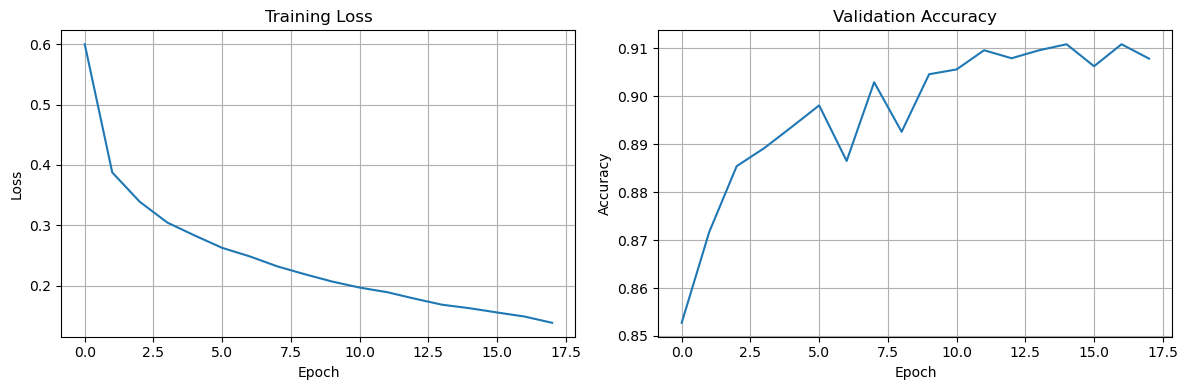

In [16]:
import copy
# Write code for task 3 here

# Setting a random seed for reproducibility
torch.manual_seed(2025)

class ConvNN(torch.nn.Module):
    """Definition of a convolutional neural network for classification 
    in Pytorch, inheriting from the torch.nn.Module base class."""
    def __init__(self):
        super().__init__()
        # TODO: finish constructor/initialization
        self.convolutional_pooling_layers = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size = (3, 3), padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(12, 15, kernel_size = (3, 3), padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        self.connected_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(15 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        """ Compute logits for batch x by forward propagation.
        Parameters
        ----------
        x : tensor, shape = [n_examples, n_channels, width, height]
        """
        # TODO: finish constructor/initialization
        x = self.convolutional_pooling_layers(x)
        x = self.connected_layers(x)
        return x

def training_cnn(device, max_epochs = 20, patience = 3, lr = 0.001):
    model = ConvNN().to(device)
    CEL = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    s = 0
    best_accuracy = 0.0
    train_losses = []
    val_accuracies = []
    best_model = None
    start_time = time.time()
    for epoch in range(1, max_epochs + 1):
        model.train()
        sum_loss = 0.0
        n_train = 0
        for x, y in train_loader:
            xb = x.to(device)
            yb = y.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = CEL(logits, yb)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)
        average_train_loss = sum_loss / n_train
        train_losses.append(average_train_loss)
        model.eval()
        with torch.no_grad():
            correct = 0
            n = 0
            for x, y in val_loader:
                xb = x.to(device)
                yb = y.to(device)
                correct += (model(xb).argmax(1) == yb).sum().item()
                n += yb.size(0)
            val_accuracy = correct / n
            val_accuracies.append(val_accuracy)
        print(device, "Epoch", epoch, ": Training Loss", average_train_loss, "| Validation Accuracy", val_accuracy)
        if val_accuracy > best_accuracy + 0.0001:
            best_accuracy = val_accuracy
            s = 0
            best_model = copy.deepcopy(model).to(device).eval()
        else:
            s += 1
            if s >= patience:
                break
    training_time = time.time() - start_time
    total_parameters = sum(param.numel() for param in model.parameters())
    testing_model = best_model if best_model is not None else model
    return testing_model, train_losses, val_accuracies, best_accuracy, training_time, total_parameters

CNN_model, CNN_train_losses, CNN_val_accuracies, CNN_best_accuracy, CNN_time, CNN_total_parameters = training_cnn(my_device)
print("The device I used is", my_device_name)
print("The best validation accuracy is", CNN_best_accuracy)
print("The total number of parameters is", CNN_total_parameters)
print("The training time is", CNN_time)
plot_training_curves(CNN_train_losses, CNN_val_accuracies)

We went from 28x28 to 14x14 to 7x7. For the first convolutional layer, there are 120 parameters ((1 X 12 X 3 X 3) + 12 = 120) since there are 108 weights (1 X 12 X 3 X 3 = 108) and 12 biases. For the second convolutional layer, there are 1,635 parameters ((12 X 15 X 3 X 3) + 15 = 1,635) since there are 1,620 weights (12 X 15 X 3 X 3 = 1,620) and 15 biases. For the first linear layer, there are 73,600 parameters (((15 X 7 X 7) X 100) + 100 = 73,600) since there are 73,500 weights ((15 X 7 X 7) = 73,500) and 100 biases. For the second layer, there are 1,010 parameters since there are 1,000 weights (100 X 10 = 1,000) and 10 biases. So all together, there are 76,365 parameters in total (120 + 1,635 + 73,600 + 1,010 = 76,365). As for training time, it varies but it is somewhere between 85 and 87 seconds.

## Task 4

In this task you will use dropout regularization during training to improve the generalization of your convolutional neural network.

1. Before adding dropout, let's establish a baseline. Take your best model from Task 3 (the one that achieved the highest validation accuracy) and evaluate its performance on the `test_loader` (which has not been used until now), to obtain the **test accuracy without Dropout**. Report this test accuracy.

2. Second, modify your convolutional neural network architecture that you defined in Task 3 to **use Dropout to improve generalization.** Specifically, add a [PyTorch Dropout layer](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) after the hidden linear layer that comes right before the output layer with a drop rate `p = 0.2` (this is lower than the default). Then train the model exactly as you did in Task 3.

3. Finally, evaluate the the model of Step 2 with `test_loader` and report the test accuracy. Then report the accuracy difference before and after applying Dropout. You should observe an improvement in test accuracy after adding Dropout.

In [19]:
# Write code for task 4 here

# Setting a random seed for reproducibility
torch.manual_seed(2025)

@torch.no_grad()
def test_accuracy(model, device, t_loader):
    model.eval()
    correct = 0
    n = 0
    for x, y in t_loader:
        xb = x.to(device)
        yb = y.to(device)
        correct += (model(xb).argmax(1) == yb).sum().item()
        n += yb.size(0)
        accuracy = correct / n
    return accuracy

without_dropout_test_accuracy = test_accuracy(CNN_model, my_device, test_loader)

class ConvNNWithDropout(ConvNN):
    def __init__(self):
        super().__init__()
        self.connected_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(15 * 7 * 7, 100),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(100, 10)
        )

def training_cnn_dropout(device, max_epochs = 20, patience = 3, lr = 0.001):
    model = ConvNNWithDropout().to(device)
    CEL = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    s = 0
    best_accuracy = 0.0
    train_losses = []
    val_accuracies = []
    best_model = None
    start_time = time.time()
    for epoch in range(1, max_epochs + 1):
        model.train()
        sum_loss = 0.0
        n_train = 0
        for x, y in train_loader:
            xb = x.to(device)
            yb = y.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = CEL(logits, yb)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)
        average_train_loss = sum_loss / n_train
        train_losses.append(average_train_loss)
        model.eval()
        with torch.no_grad():
            correct = 0
            n = 0
            for x, y in val_loader:
                xb = x.to(device)
                yb = y.to(device)
                correct += (model(xb).argmax(1) == yb).sum().item()
                n += yb.size(0)
            val_accuracy = correct / n
            val_accuracies.append(val_accuracy)
        print(device, "Epoch", epoch, ": Training Loss", average_train_loss, "| Validation Accuracy", val_accuracy)
        if val_accuracy > best_accuracy + 0.0001:
            best_accuracy = val_accuracy
            s = 0
            best_model = copy.deepcopy(model).to(device).eval()
        else:
            s += 1
            if s >= patience:
                break
    training_time = time.time() - start_time
    total_parameters = sum(param.numel() for param in model.parameters())
    testing_model = best_model if best_model is not None else model
    return testing_model, train_losses, val_accuracies, best_accuracy, training_time, total_parameters

Dropout_model, Dropout_train_losses, Dropout_val_accuracies, Dropout_best_accuracy, Dropout_time, Dropout_total_parameters = training_cnn_dropout(my_device)
with_dropout_test_accuracy = test_accuracy(Dropout_model, my_device, test_loader)
accuracy_difference = with_dropout_test_accuracy - without_dropout_test_accuracy
print("The device I used is", my_device_name)
print("The best validation accuracy with with dropout is", Dropout_best_accuracy)
print("The training time with dropout is", Dropout_time)
print("The test accuracy without dropout is", without_dropout_test_accuracy * 100, "%.")
print("The test accuracy with dropout is", with_dropout_test_accuracy * 100, "%.")
print("The accuracy difference before and after applying dropout is", accuracy_difference * 100, "%.")

mps Epoch 1 : Training Loss 0.6526633073290189 | Validation Accuracy 0.8454166666666667
mps Epoch 2 : Training Loss 0.4001561727921168 | Validation Accuracy 0.8781666666666667
mps Epoch 3 : Training Loss 0.3499237622419993 | Validation Accuracy 0.8876666666666667
mps Epoch 4 : Training Loss 0.31546806505322456 | Validation Accuracy 0.8945
mps Epoch 5 : Training Loss 0.29803555582960445 | Validation Accuracy 0.8989166666666667
mps Epoch 6 : Training Loss 0.2803105530043443 | Validation Accuracy 0.9025
mps Epoch 7 : Training Loss 0.26500231274962427 | Validation Accuracy 0.894
mps Epoch 8 : Training Loss 0.2509073841869831 | Validation Accuracy 0.9011666666666667
mps Epoch 9 : Training Loss 0.24106518764297166 | Validation Accuracy 0.9119166666666667
mps Epoch 10 : Training Loss 0.23006856665511927 | Validation Accuracy 0.9090833333333334
mps Epoch 11 : Training Loss 0.22132279721895853 | Validation Accuracy 0.9109166666666667
mps Epoch 12 : Training Loss 0.21061374480525652 | Validation

The test accuracy with dropout is 90.36% while the test accuracy without dropout is 90.79%. This means that the accuracy difference is -0.43%. I believe that my model from task 3 already does well with generalization, so I think that the effect of dropout did not yield a measurable improvement in the test accuracy in this case.